# BC @5m

**Goal:** find a `MinProfitableAccAvg(#ahead)` function.

For:
* `Acc = 0.5 + eps`

...amount gained can be computed by noting that:
* `0.5 + eps` of the time we predict correctly
* `0.5 - eps` of the time me predict incorrectly
* when we predict correctly  win on average `std(#ahead)` (times traded quantity but we can take it to be 1 here)

...so on average we gain:
* `(0.5 + eps) * std - (0.5 - eps) * std = 2 * eps * std`

To make a profit we must gain more than the costs of operating the strategy, which are made up of (times qty, but it's 1):
* a % transction fee: `fee`
* the bid-ask spread: `spread`

So our profit function looks like this:
* `Profit(#ahead, eps) = 2 * eps * std(#ahead) - fee - spread`

So our function needs to find for each `#ahead` the minimump `eps` (searching up to a max) for which `Profit` is 0 (and the accuracy is 0.5 plus that eps ofc).

Ergo:
* `MinProfitableAcc(#ahead) = (fee+spread) / (2*std(#ahead)) + 0.5`

In [1]:
#%% Setup stuff
#################################################
# pretty printers and displayers
import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image
# import numpy and pandas
import numpy as np
import pandas as pd
# Pyplot
%matplotlib inline
import matplotlib.pyplot as plt
# Seaborn - api only no themes
# import seaborn as sns
import seaborn.apionly as sns
# import 3rd party libs
import time
import math
import datetime as dtm
from functools import partial
# inport project helpers
import helpers as helpers
import visuals as viz
from helpers import peekdf as peek

/home/neuronq/miniconda3/envs/ucapstone/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/neuronq/miniconda3/envs/ucapstone/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
BC_5M_F_FILENAME = '../clean_data/bitcoin/bc_5m_f2_gdx.csv'

In [3]:
data_bc_5m = helpers.load_csv(BC_5M_F_FILENAME, index_col='timestamp')
data_bc_5m = data_bc_5m[::-1]
dd(data_bc_5m[:3])
print "Entries:", len(data_bc_5m)
pp(data_bc_5m.dtypes)

,datetime,low,high,open,close,volume,year,month,day
timestamp,,,,,,,,,
1422749070,2015-02-01 00:04:30,218.60,219.49,218.67,218.60,38.804249,2015,2,1
1422749370,2015-02-01 00:09:30,218.28,218.54,218.52,218.28,17.182333,2015,2,1
1422749670,2015-02-01 00:14:30,218.24,218.37,218.36,218.24,13.874533,2015,2,1


Entries: 245088
datetime     object
low         float64
high        float64
open        float64
close       float64
volume      float64
year          int64
month         int64
day           int64
dtype: object


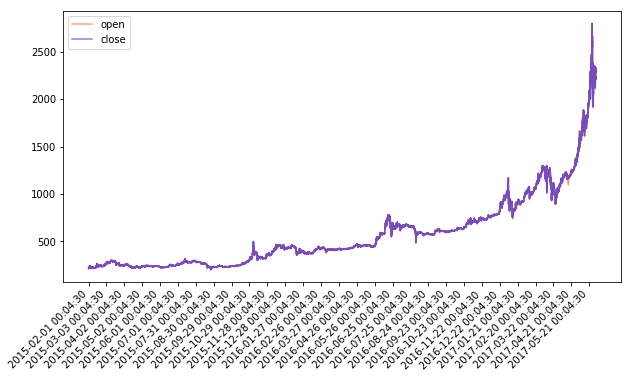

In [4]:
viz.simple_plot(data_bc_5m, xticks_span=24 * 60 * 30 / 5)

In [5]:
cdata = data_bc_5m['close'].values

## STDEV @100

In [37]:
def stdev(data, at):
    out = np.zeros(len(data) - at, dtype=np.float64)
    for i in xrange(len(data) - at):
        out[i] = data[i: i + at].std()
    return out

def plot_stdev(data, at):
    stdevs = stdev(data, at)
    xs = np.arange(len(stdevs))
    avg = np.average(stdevs)
    plt.figure(figsize=(15, 5))
    plt.plot(xs, stdevs, color='k', linewidth=1)
    plt.plot(xs, [avg] * len(xs), color='r', linewidth=1)
    print "average: %f" % avg

average: 3.346387


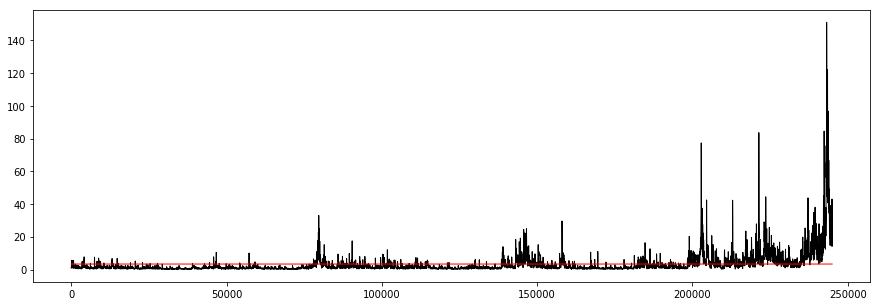

In [38]:
plot_stdev(cdata, at=100)

average: 1.719767


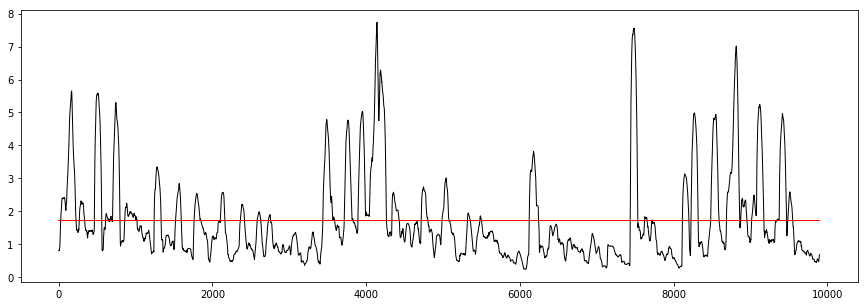

In [39]:
plot_stdev(cdata[:10000], at=100)

average: 1.133688


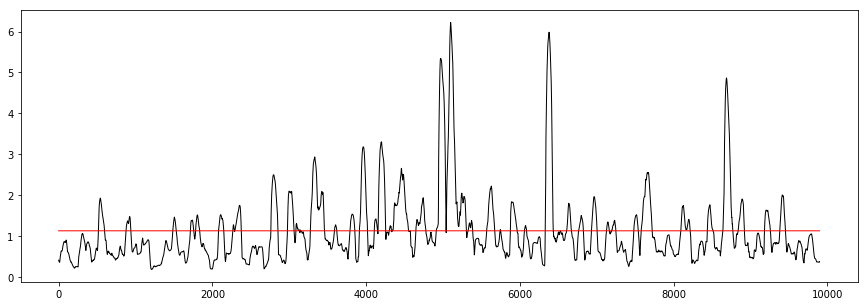

In [41]:
plot_stdev(cdata[125000:135000], at=100)

average: 21.839209


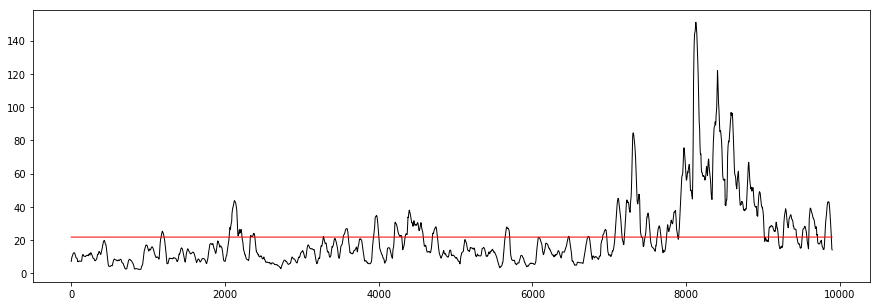

In [40]:
plot_stdev(cdata[-10000:], at=100)

### Min-Acc @100

In [52]:
def min_acc(data, at, min_eps_ct=0.15):
    out = np.zeros(len(data) - at, dtype=np.float64)
    for i in xrange(len(data) - at):
        out[i] = min_eps_ct / data[i: i + at].std()
    return out + 0.5

def plot_min_acc(data, at, min_eps_ct=0.15):
    min_accs = min_acc(data, 100, min_eps_ct)
    avg = np.average(min_accs)
    xs = np.arange(len(min_accs))
    plt.figure(figsize=(15, 5))
    plt.plot(xs, min_accs, color='g', linewidth=1)
    plt.plot(xs, [avg] * len(xs), color='r', linewidth=1)
    print "average: %f" % avg

average: 0.653369


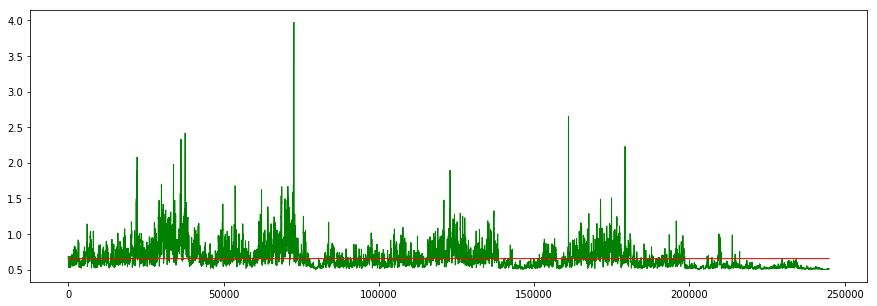

In [53]:
plot_min_acc(cdata, 100)

average: 0.637886


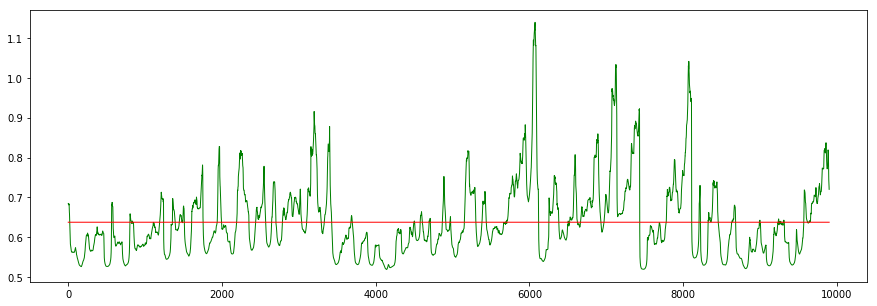

In [54]:
plot_min_acc(cdata[:10000], 100)

average: 0.694084


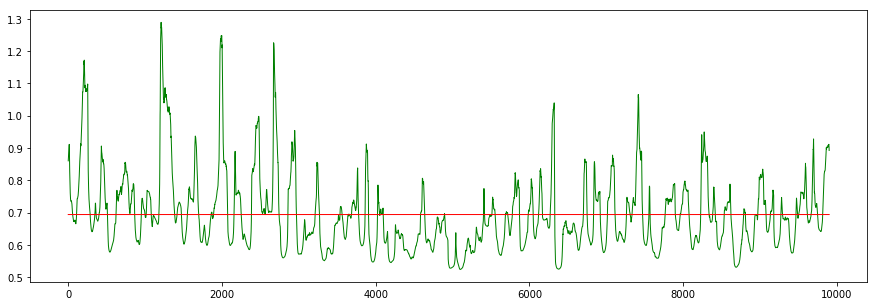

In [56]:
plot_min_acc(cdata[125000:135000], 100)

average: 0.511958


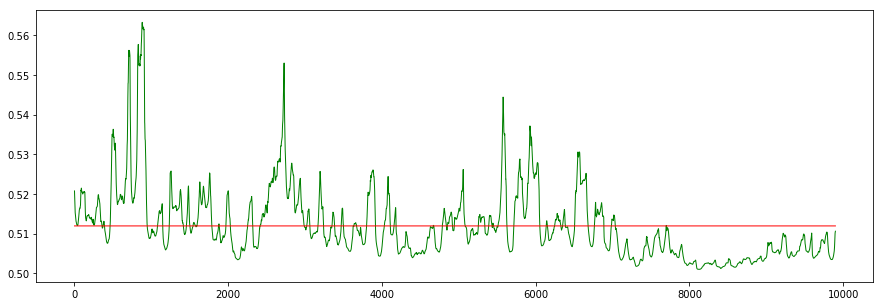

In [58]:
plot_min_acc(cdata[-10000:], 100)

## Min-Acc( #ahead )

In [78]:
def min_acc_by_ahead(data, ahead, min_eps_ct=0.15):
    out = np.zeros(ahead, dtype=np.float64)
    zeros = 0
    for i in xrange(len(data) - ahead):
        for j in xrange(5, ahead):
            std = data[i: i + j].std()
            if std == 0:
                zeros += 1
                continue
            out[j] += min_eps_ct / std
    out[5:] /= len(data) - ahead - zeros
    print "    (%d stdevs of 0 found)" % zeros
    out += 0.5
    return out

def plot_min_acc_by_ahead(data, ahead, min_eps_ct=0.15):
    min_accs = min_acc_by_ahead(data, ahead, 0.15)
    xs = np.arange(70, len(min_accs))
    plt.figure(figsize=(15, 5))
    plt.plot(xs, min_accs[70:], color='b', linewidth=1)
    plt.plot(xs, np.ones(len(xs)) * min_accs[100], color='r', linewidth=1)
    plt.axvline(x=100, color='r', linewidth=0.5)
    print "@ 100: %f" % min_accs[100]

    (1 stdevs of 0 found)
@ 100: 0.637113


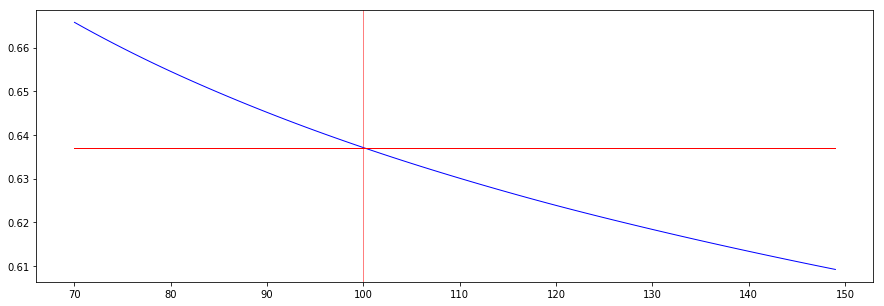

In [79]:
plot_min_acc_by_ahead(cdata[:10000], 150, 0.15)

    (42 stdevs of 0 found)
@ 100: 0.693887


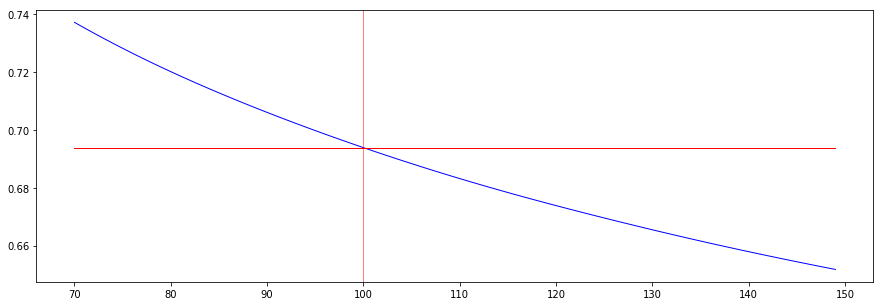

In [80]:
plot_min_acc_by_ahead(cdata[125000: 135000], 150, 0.15)

    (12 stdevs of 0 found)
@ 100: 0.512006


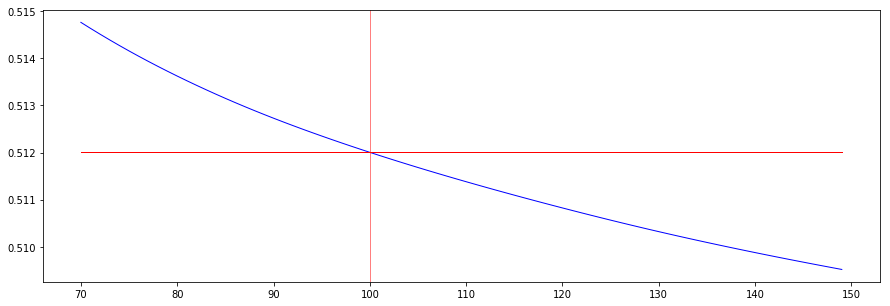

In [81]:
plot_min_acc_by_ahead(cdata[-10000:], 150, 0.15)